此部分是針對Numeric feature做一些EDA，希望找出有保險的人(Y1= 1)在numeric feature中是否隱藏了一些特徵


In [1]:
#import 需要的套件
import os
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


### Read and Observe the Data   
Training Data:(100000, 132)   
Testing Data:(150000, 131)  

training is one column more than test(Since they had the ANSWER "Y1" for whether they have insurance)  

In [2]:
train = pd.read_csv('train.csv',encoding = 'big5')
test = pd.read_csv('test.csv',encoding = 'big5')

print(train.shape,test.shape)

/Users/liaoshousan/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (17,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(100000, 132) (150000, 131)


###  How many people have bought insurance

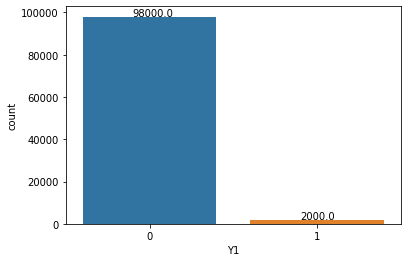

In [9]:
LE = LabelEncoder()
train['Y1'] = LE.fit_transform(train['Y1']) #transform Y1 into binary

ax = sns.countplot('Y1',data = train)
for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+100))


##### Obviously, it was an imbalance dataset.
##### Hence,we should do some feature engineering and stuff like SMOTE  later

## To start the project, we first observe the correlation between Y1 and other x variables

In [13]:

k = 15 #Top 15 and Last 15 variables correated with Y1相關係數最高(低)的前15名
r_largest = train.corr().nlargest(k, 'Y1')['Y1']
r_smallest = train.corr().nsmallest(k, 'Y1')['Y1']


print('The top 15 coefficient correlation with Y1')
print(r_largest)
print()
print('-' *100)
print()
print('The down 15 coefficient correlation with Y1')
print(r_smallest)

# It seems that there's no directly linear relationship between Y1 and other variables.


The top 15 coefficient correlation with Y1
Y1                      1.000000
L1YR_A_ISSUE_CNT        0.121897
AG_NOW_CNT              0.101031
CHANNEL_A_POL_CNT       0.096635
TOOL_VISIT_1YEAR_CNT    0.094471
LEVEL                   0.093061
CLC_CUR_NUM             0.084761
BANK_NUMBER_CNT         0.074727
LIFE_INSD_CNT           0.072510
IM_CNT                  0.071781
EDUCATION_CD            0.070994
DIEACCIDENT_AMT         0.067110
RFM_M_LEVEL             0.066244
AG_CNT                  0.065327
INSD_CNT                0.056089
Name: Y1, dtype: float64

----------------------------------------------------------------------------------------------------

The down 15 coefficient correlation with Y1
APC_1ST_YEARDIF          -0.041038
TERMINATION_RATE         -0.035819
APC_CNT                  -0.026388
INSD_LAST_YEARDIF_CNT    -0.016299
EXPIRATION_AMT           -0.000902
FIRST_CANCER_AMT          0.001739
L1YR_B_ISSUE_CNT          0.003821
ANNUAL_INCOME_AMT         0.005273
POLICY_VAL

### If you are curious about the detail of correlation between variables, we could visualize it with heatmap

(15.0, 0.0)

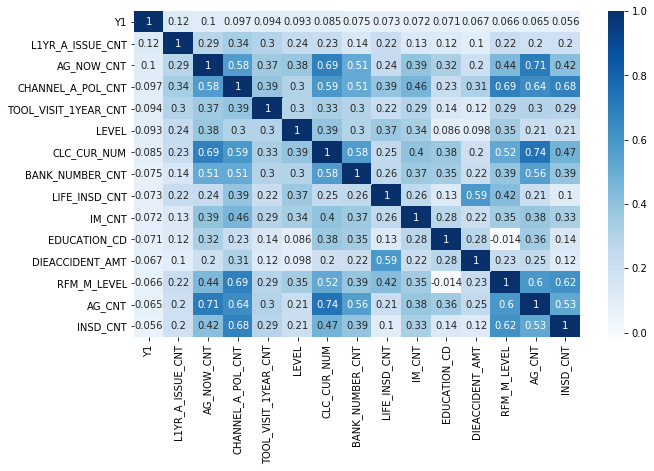

In [14]:
cols = train.corr().nlargest(k, 'Y1')['Y1'].index
cm = train[cols].corr()
plt.figure(figsize=(10,6))
ax = sns.heatmap(cm,
                 annot=True,
                 cmap = 'Blues')

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5) #this line of code is for tidylayout



## EDA探索有空值的欄位特質
### 補空值
- EDUCATION_CD (教育程度，K-MEANS，可能可以參考年齡、性別)
- MARRIAGE_CD (可能與男女結婚比例)
- OCCUPATION_CLASS_CD (客戶職業對投保風險程度,可以按比例填or眾數)
- L1YR_A_ISSUE_CNT (近一年透過A通路投保的次數,眾數1 佔90%)
- APC_1ST_YEARDIF (距離首次成為要保人相隔時間, 呈現很詭異的分佈要馬隔很短要馬隔很久，問教授)
- LEVEL(往來關係等級,雙峰趨勢)
- APC_1ST_AGE(首次擔任要保人的年齡,呈現季節高峰，可能跟推廣季有關，查time-series)
- RFM_M_LEVEL(距離上次投保間隔多久)
- ANNUAL_PREMIUM_AMT(年繳化保費,超偏態分佈，要搜尋一下怎麼填空值)
- L1YR_C_CNT(近一年內到C通路辦保險的次數，缺太多考慮丟掉)
- INSD_LAST_YEARDIF_CNT(雖便填個平均值交差了事)

先前先不管空值為何  
只要是objected的空值就填入眾數 numeric就填入0  
現在我們要詳細觀察如何填入空值可以盡量縮小誤差  

# Let's start EDA and extract valuable information!

### Education

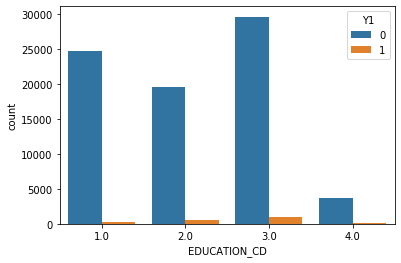

In [15]:
# use coutplot to see if there are different preference in education level
sns.countplot(x = 'EDUCATION_CD',hue = 'Y1',data = train) 


### Gender

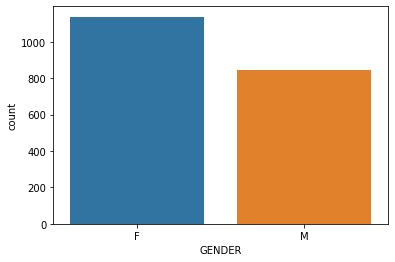

In [16]:
#Since there are too much people that don't buy insurance,we only look at people who buys insurance
# It seems that female is more prone to buy insurance, but should do proportion test further.
sns.countplot(train[train['Y1']==1]['GENDER'])  

### Proportion test

In [37]:
FYes = train[(train['Y1']==1) & (train['GENDER']=='F')].shape[0] # total number Female buy insurane
FNo = train[(train['Y1']==0) & (train['GENDER']=='F')].shape[0] # total number Female not buy insurane
MYes = train[(train['Y1']==1) & (train['GENDER']=='M')].shape[0] # total number Male buy insurane
MNo = train[(train['Y1']==0) & (train['GENDER']=='M')].shape[0] # total number Male not buy insurane

survivors = np.array([[FYes,FNo], [MYes, MNo]])
proptest = stats.chi2_contingency(survivors)

print(' test statistic is {}\n p-value is {}\n degree of freedom is {}'.format(proptest[0],proptest[1],proptest[2]))
# The difference of buying rate is significant at 5% alpha rate

 test statistic is 13.398702098846579
 p-value is 0.0002517984699424579
 degree of freedom is 1


### Occupation

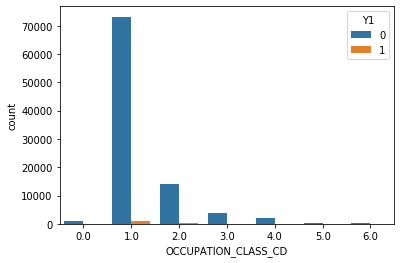

In [38]:
# use coutplot to see if there are different preference in Occupation level
# Though occupation1 buy a lot,whey have bigger basis comparing other occupation,so it is necessary to test hypothesis.
sns.countplot(x = 'OCCUPATION_CLASS_CD',hue = 'Y1',data = train)  

### 首次成為要保人距今間隔時間

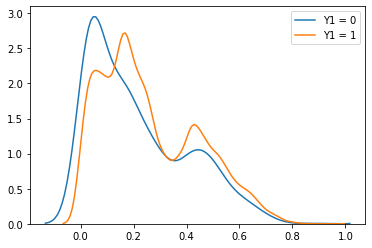

In [51]:
# APC_1ST_YEARDIF的欄位意涵：首次成為要保人距今間隔時間(年)
# 時間越長和國泰的關係理應沒那麼親密，保險的意願可能也較低
# 下圖可以觀察出：有買保險的人，和沒買保險的人，在首次成為要保人距今間隔時間是否有差異
# 這樣看起起來好像沒有太大的差異，可能不是顯著的變數

dropAPC_1ST_YEARDIF = train.dropna(subset=['APC_1ST_YEARDIF'])
a = dropAPC_1ST_YEARDIF[dropAPC_1ST_YEARDIF['Y1']==1]['APC_1ST_YEARDIF'] 
b = dropAPC_1ST_YEARDIF[dropAPC_1ST_YEARDIF['Y1']==0]['APC_1ST_YEARDIF']
sns.kdeplot(a,label = 'Y1 = 0') 
sns.kdeplot(b,label = 'Y1 = 1')
plt.legend()




### 和國泰的往來關係等級(1~5 級)

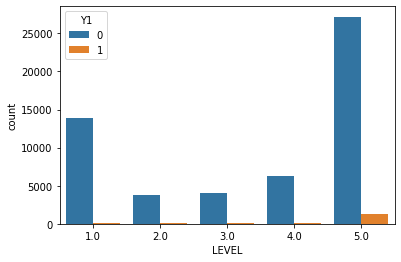

In [54]:
#Level:和國泰的往來關係等級(1~5 級)
#照理說等級越高，越信任國泰，買重疾險的機率就越高
#從下圖可以看出，Level 5 的人滿明顯的在購買重疾險上多出其他等級的人不少
sns.countplot('LEVEL', hue='Y1',data = train)


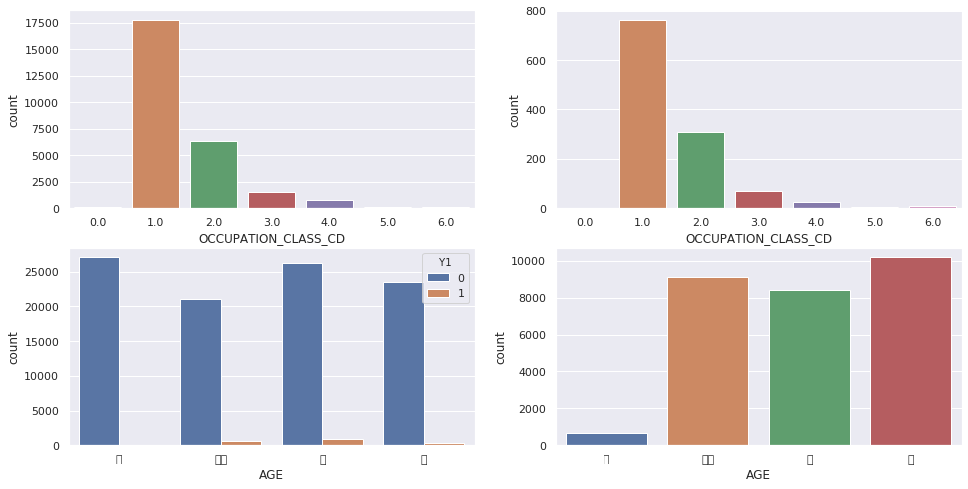

In [114]:
# 想進一步觀察Level 5的人都是哪種人(ex:職業 / 年紀)

plt.figure(figsize=(16,8))
plt.subplot(221)
level5_0 = train[(train['LEVEL']==5)&(train['Y1']==0)]
sns.countplot('OCCUPATION_CLASS_CD',data = level5_0)

plt.subplot(222)
level5_1 = train[(train['LEVEL']==5)&(train['Y1']==1)]
sns.countplot('OCCUPATION_CLASS_CD',data = level5_1)

# 從下圖可以發現 與國泰關係良好的人之中，大部分集中於Occupation1
# Level=5 且有保險的人，分配與Level=5 沒保險的人差不多



#觀察年紀是否對購買保險意願有影響(似乎以中年&中高年為主)
#可能他們的保費還在可接受的範圍 因為太老太貴 太年輕對部分不太在乎
plt.subplot(223)
sns.countplot('AGE',hue = 'Y1',data = train)

#最後，我想看LEVEL5的人年紀都落在什麼區間
#可以看出LEVEL5的人顯然都不是年輕人，推測是小康白領(年輕人較難爬到的位置)
plt.subplot(224)
level5 = train[(train['LEVEL']==5)]
sns.countplot('AGE',data = level5)



### 曾投保主約件數

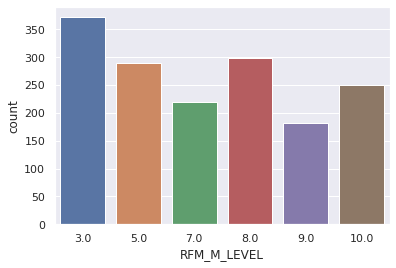

In [121]:
#RFM_M_LEVEL:曾投保主約件數(越高應該可以推測其與國泰關係越親密)
# 看來曾投保主約件數並非顯著特徵 (不過還是可以用假設檢定檢查一下)
sns.countplot('RFM_M_LEVEL' , data = train[train['Y1']==1])

### 年繳化保費

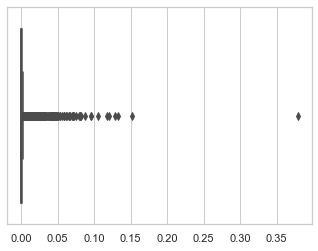

In [169]:
#ANNUAL_PREMIUM_AMT:年繳化保費，這應該是個很重要的特徵
#一般來說保費可以對應到一個人的「健康狀況、職業危險、年紀大小」等等
plt.figure(figsize=(12,4))
train['ANNUAL_PREMIUM_AMT'].describe() #從Describe中可以看出10萬筆資料其實只有3.7萬筆有填值，且Max離群的超嚴重
plt.subplot(121)
sns.boxplot(x = ["ANNUAL_PREMIUM_AMT"],data = train) #涵蓋outliers
# plt.subplot(122)
# sns.boxplot(x = ["ANNUAL_PREMIUM_AMT"],data = train,showfliers = False) #不涵蓋outliers


In [224]:
#延續上一動作，我想知道有保險的人 保費會不會比較高
#先拿掉保費離群值
Q1 = train['ANNUAL_PREMIUM_AMT'].quantile(0.25)
Q3 = train['ANNUAL_PREMIUM_AMT'].quantile(0.75)
whisker = (Q3-Q1)*3
whisker_high = Q3+whisker 
whisker_low = Q1-whisker

#挑出 ANNUAL_PREMIUM_AMT 介在whisker_low / whisker_high之間的
rm_outliers = train[train['ANNUAL_PREMIUM_AMT'].between(whisker_low,whisker_high)]
print(rm_outliers[rm_outliers['Y1']==0]['ANNUAL_PREMIUM_AMT'].mean())
print(rm_outliers[rm_outliers['Y1']==1]['ANNUAL_PREMIUM_AMT'].mean())

#沒保重疾險的人平均保費較有保的人低(仍須透過假設檢定做判斷)
#推測
#1.有保的人社經地位較高，有較高的機率願意花比較多錢買保險
#2.重疾險本身就是較含有高的保費

#疑慮：whisker要多設幾個來比較，因為這個東西離群值比較誇張

0.0006278004053774846
0.0007766522712392831


### 年收入

In [230]:
# 年收入 (神秘轉換&歸一化):做跟上面一樣的事情，結束後順便看看年收入和年保費的相關性

Q1 = train['ANNUAL_INCOME_AMT'].quantile(0.25)
Q3 = train['ANNUAL_INCOME_AMT'].quantile(0.75)
whisker = (Q3-Q1)*3
whisker_high = Q3+whisker 
whisker_low = Q1-whisker


rm_outliers = train[train['ANNUAL_INCOME_AMT'].between(whisker_low,whisker_high)]
print(rm_outliers[rm_outliers['Y1']==0]['ANNUAL_INCOME_AMT'].mean())
print(rm_outliers[rm_outliers['Y1']==1]['ANNUAL_INCOME_AMT'].mean())

#沒保重疾險的人平均年收入較有保的人低(仍須透過假設檢定做判斷)
#疑慮：whisker要多設幾個來比較，因為這個東西離群值比較誇張


0.0005068043206064134
0.000563912264077675


In [241]:
print('收入和保費的相關係數為%.2f' %(train['ANNUAL_INCOME_AMT'].corr(train['ANNUAL_PREMIUM_AMT'])))


收入和保費的相關係數為0.22


### 近一年到 C 通路申辦服務次數

In [243]:
train['L1YR_C_CNT'].isna().sum() #缺值比例竟高達88% 考慮不用
#缺太多考慮丟掉

87936

### 最近一次被保人身份投保距今間隔時間

Text(0.5, 1.0, 'INSD_LAST_YEARDIF_CNT Difference Between Y1=0/1')

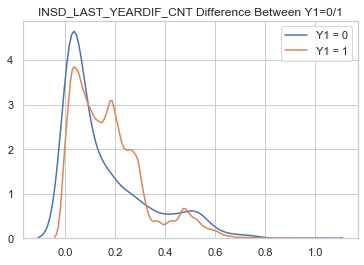

In [251]:
# INSD_LAST_YEARDIF_CNT：最近一次被保人身份投保距今間隔時間(年) 
# 照理來說距離越近，和國泰的關係淡的沒那麼快
# 這個我真的不知道要用什麼解釋了

dropINSD_LAST_YEARDIF_CNT = train.dropna(subset=['INSD_LAST_YEARDIF_CNT'])
x = dropINSD_LAST_YEARDIF_CNT[dropINSD_LAST_YEARDIF_CNT['Y1']==1]['INSD_LAST_YEARDIF_CNT'] 
y = dropINSD_LAST_YEARDIF_CNT[dropINSD_LAST_YEARDIF_CNT['Y1']==0]['INSD_LAST_YEARDIF_CNT']
sns.kdeplot(x,label = 'Y1 = 0') 
sns.kdeplot(y,label = 'Y1 = 1')
plt.legend()
plt.title('INSD_LAST_YEARDIF_CNT Difference Between Y1=0/1')

